<a href="https://colab.research.google.com/github/HNXJ/PredictiveCodingNetwork/blob/main/PredictiveLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np


# GPU config if needed
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Recurrent neural network based on predictive coding properties

In this simulation, we will use task of [Abdullahi et. al 2020] by increasing temporal resolution from one image per step to 10 iterations for each input.

In [2]:
# TB
# dir(tf.keras.layers.LSTM)

In [3]:
def create_serial_dataset(x=None, y=None, n=100, length=10, frames=10):

    X = np.zeros([n, length*frames, x.shape[1], x.shape[2]])
    Y = np.zeros([n, length*frames, 10])

    for i in range(n):

        k = np.random.randint(0, 1000, size=(length))
        for j in range(length):
          
            X[i, j*frames:j*frames+frames, :, :] = x[k[j], :, :]
            Y[i, j*frames:j*frames+frames, y[k[j]]] = 1
          
    return X.reshape(n, length*frames, x.shape[1] * x.shape[2]), Y

def init_MNIST():

    (x_train,y_train), (x_test,y_test) = tf.keras.datasets.mnist.load_data()
    Xn, Yn = create_serial_dataset(x_train, y_train, n=100, length=10, frames=10)
    Xn /= 255.0
    Yn /= 255.0
    X = Xn[:10, :, :]
    Y = Yn[:10, :, :]
    return X, Y, Xn, Yn

In [4]:
class RNNModel1(tf.keras.Model):
    def __init__(self):
        super(RNNModel1, self).__init__()
        self.Input = (tf.keras.layers.InputLayer(input_shape=(None, 784)))
        self.LSTM = tf.keras.layers.LSTM(input_shape=(None, 784),
          units=512,
          recurrent_dropout=0.2,
          return_sequences=True,
          # return_state=True
        )
        self.FCN = tf.keras.layers.Dense(units=10)
        return 
        
    def call(self, x):
        out = self.Input(x)
        out = self.LSTM(x)
        out = self.FCN(out)
        return out

    def get_state(self):
        return

In [5]:
class PredictiveNet():
    def __init__(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.InputLayer(input_shape=(None, 784)))
        self.model.add(tf.keras.layers.LSTM(
          units=512,
          recurrent_dropout=0.2,
          return_sequences=True,
          # return_state=True
        ))
        self.model.add(tf.keras.layers.Dense(units=10))
        self.lastPreactivation = None
        return

    def printw(self): # Debug log
        print(K.mean(self.model.layers[1].weights[0]))
        return

    def getPreactivation(self, x):
        MTemp = K.function([self.model.layers[0].input],
                                  [self.model.layers[1].input])
        stateVector = MTemp(x)
        self.lastPreactivation = stateVector[0]
        return self.lastPreactivation

    def EnergyCostLoss(self, y_true, y_pred):
        error = y_pred - y_true
        lambda1 = 1.2
        lambda2 = 0.0
        lambda3 = 0.0
        # preact = self.lastPreactivation
        return K.mean(K.square(error) + lambda1*K.mean(K.abs(y_pred))) + lambda2*K.mean(K.abs(self.model.layers[0].weights[0])) + lambda3*K.mean(K.abs(self.model.layers[1].weights[0]))

In [6]:
X, Y, Xn, Yn = init_MNIST()
Net1 = PredictiveNet()
# a = model.predict(Xn[1:2, :, :])
Net1.model.compile(
  loss=Net1.EnergyCostLoss,
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)
Net1.model.summary()

Net1.printw()


11493376/11490434 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 512)         2656256   
_________________________________________________________________
dense (Dense)                (None, None, 10)          5130      
Total params: 2,661,386
Trainable params: 2,661,386
Non-trainable params: 0
_________________________________________________________________
tf.Tensor(0.0013962194, shape=(), dtype=float32)


In [7]:
means1 = []
means1a = []

for k in range(10):
    l, r = k, k+1
    l_pred = Net1.getPreactivation(Xn[l:r, :, :])
    y_pred = Net1.model.predict(Xn[l:r, :, :])

    # for i in range(7):
        # plt.plot(l_pred[0][0, :, i])
    # for i in range(10):
    # plt.plot(y_pred[0, :, 6])
    # for i in range(0, 100, 10):
    #     print(Yn[l:r, i, :])
    means1.append(np.mean(np.mean(l_pred)))
    means1a.append(np.mean(np.mean(np.abs(l_pred))))

In [8]:
means2 = []
means2a = []

for k in range(10, 30):
    l, r = k, k+1
    l_pred = Net1.getPreactivation(Xn[l:r, :, :])
    y_pred = Net1.model.predict(Xn[l:r, :, :])

    # for i in range(7):
    #     plt.plot(l_pred[0, i, :])
    # for i in range(10):
    # plt.plot(y_pred[0, :, 6])
    # for i in range(0, 100, 10):
    #     print(Yn[l:r, i, :])
    means2.append(np.mean(np.mean(l_pred)))
    means2a.append(np.mean(np.mean(np.abs(l_pred))))

In [9]:
print("Mean energy on recurrent preactivation (LSTM) on sigmoid activation function before training")
print(np.mean(means1), np.mean(means2), "(ME)")
print(np.mean(means1a), np.mean(means2a), "(MAE)")
print(100*np.abs(np.mean(means1)-np.mean(means2))/np.mean(means1), "(Difference ratio, percentage %)")
print(100*np.abs(np.mean(means1a)-np.mean(means2a))/np.mean(means1a), "(Difference abs ratio, percentage %)")

Mean energy on recurrent preactivation (LSTM) on sigmoid activation function before training
-0.00020369247 1.669759e-05 (ME)
0.14919743 0.14980337 (MAE)
-108.19745328498233 (Difference ratio, percentage %)
0.40613355146132774 (Difference abs ratio, percentage %)


In [10]:
history = Net1.model.fit(
    x=X, y=Y,
    epochs=100,
    batch_size=5,
    validation_split=0.0,
    verbose=1,
    shuffle=True
)

Epoch 1/100
2/2 [==============================] - 3s 346ms/step - loss: 0.9948
Epoch 2/100
2/2 [==============================] - 1s 298ms/step - loss: 0.4441
Epoch 3/100
2/2 [==============================] - 1s 308ms/step - loss: 0.3157
Epoch 4/100
2/2 [==============================] - 1s 301ms/step - loss: 0.2704
Epoch 5/100
2/2 [==============================] - 1s 308ms/step - loss: 0.1357
Epoch 6/100
2/2 [==============================] - 1s 304ms/step - loss: 0.0832
Epoch 7/100
2/2 [==============================] - 1s 303ms/step - loss: 0.1026
Epoch 8/100
2/2 [==============================] - 1s 304ms/step - loss: 0.0917
Epoch 9/100
2/2 [==============================] - 1s 297ms/step - loss: 0.0605
Epoch 10/100
2/2 [==============================] - 1s 306ms/step - loss: 0.0416
Epoch 11/100
2/2 [==============================] - 1s 305ms/step - loss: 0.0342
Epoch 12/100
2/2 [==============================] - 1s 303ms/step - loss: 0.0415
Epoch 13/100
2/2 [===================

In [11]:
# Single epoch for test
history = Net1.model.fit(
    x=X, y=Y,
    epochs=1,
    batch_size=5,
    validation_split=0.0,
    verbose=1,
    shuffle=True
)
# history2 = L1.fit(x=X, y=Y, epochs=1, batch_size=5, validation_split=0.0, verbose=1, shuffle=True)

2/2 [==============================] - 1s 305ms/step - loss: 0.0039


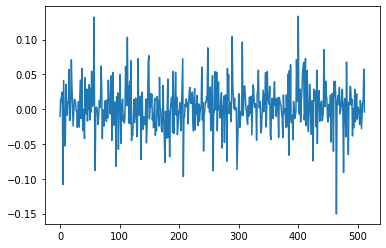

In [12]:
# for i in range(100):
Pa = Net1.getPreactivation(Xn[8:9, :, :])
plt.plot(Pa[0, 20, :])

In [13]:
means1 = []
means1a = []

for k in range(10):
    l, r = k, k+1
    l_pred = Net1.getPreactivation(Xn[l:r, :, :])
    y_pred = Net1.model.predict(Xn[l:r, :, :])

    # for i in range(7):
        # plt.plot(l_pred[0][0, :, i])
    # for i in range(10):
    # plt.plot(y_pred[0, :, 6])
    # for i in range(0, 100, 10):
    #     print(Yn[l:r, i, :])
    means1.append(np.mean(np.mean(l_pred)))
    means1a.append(np.mean(np.mean(np.abs(l_pred))))

means2 = []
means2a = []

for k in range(10, 30):
    l, r = k, k+1
    l_pred = Net1.getPreactivation(Xn[l:r, :, :])
    y_pred = Net1.model.predict(Xn[l:r, :, :])

    # for i in range(7):
    #     plt.plot(l_pred[0, i, :])
    # for i in range(10):
    # plt.plot(y_pred[0, :, 6])
    # for i in range(0, 100, 10):
    #     print(Yn[l:r, i, :])
    means2.append(np.mean(np.mean(l_pred)))
    means2a.append(np.mean(np.mean(np.abs(l_pred))))

In [14]:
print("Mean energy on recurrent preactivation (LSTM) on sigmoid activation function after training")
print(np.mean(means1), np.mean(means2), "(ME)")
print(np.mean(means1a), np.mean(means2a), "(MAE)")
print(100*np.abs(np.mean(means1)-np.mean(means2))/np.mean(means1), "(Difference ratio, percentage %)")
print(100*np.abs(np.mean(means1a)-np.mean(means2a))/np.mean(means1a), "(Difference abs ratio, percentage %)")

Mean energy on recurrent preactivation (LSTM) on sigmoid activation function after training
0.0011250929 0.001110463 (ME)
0.021287879 0.020823175 (MAE)
1.3003190861706493 (Difference ratio, percentage %)
2.182950627635711 (Difference abs ratio, percentage %)


## Lesioning the network

In this section, we've lesioned the RNN via adding a gaussian noise with mean=0 and STD=0.1 to all weights of the network as a simulation of simple lesioning.


In [15]:
Net2 = Net1
w = Net2.model.get_weights()
for i in range(2, len(w)):
    w[i] += (np.random.randn(*w[i].shape))*(np.std(w[i])*2)
Net2.model.set_weights(w)

In [16]:
# Single epoch for test
history = Net2.model.fit(
    x=X, y=Y,
    epochs=1,
    batch_size=5,
    validation_split=0.0,
    verbose=1,
    shuffle=True
)
# history2 = L1.fit(x=X, y=Y, epochs=1, batch_size=5, validation_split=0.0, verbose=1, shuffle=True)

2/2 [==============================] - 1s 346ms/step - loss: 0.2976


In [17]:
means1 = []
means1a = []

for k in range(10):
    l, r = k, k+1
    l_pred = Net2.getPreactivation(Xn[l:r, :, :])
    y_pred = Net2.model.predict(Xn[l:r, :, :])

    # for i in range(7):
        # plt.plot(l_pred[0][0, :, i])
    # for i in range(10):
    # plt.plot(y_pred[0, :, 6])
    # for i in range(0, 100, 10):
    #     print(Yn[l:r, i, :])
    means1.append(np.mean(np.mean(l_pred)))
    means1a.append(np.mean(np.mean(np.abs(l_pred))))

In [18]:
means2 = []
means2a = []

for k in range(10, 30):
    l, r = k, k+1
    l_pred = Net2.getPreactivation(Xn[l:r, :, :])
    y_pred = Net2.model.predict(Xn[l:r, :, :])

    # for i in range(7):
    #     plt.plot(l_pred[0, i, :])
    # for i in range(10):
    # plt.plot(y_pred[0, :, 6])
    # for i in range(0, 100, 10):
    #     print(Yn[l:r, i, :])
    means2.append(np.mean(np.mean(l_pred)))
    means2a.append(np.mean(np.mean(np.abs(l_pred))))

In [19]:
print("Mean energy on recurrent preactivation (LSTM) on sigmoid activation function after lesioning")
print(np.mean(means1), np.mean(means2), "(ME)")
print(np.mean(means1a), np.mean(means2a), "(MAE)")
print(100*np.abs(np.mean(means1)-np.mean(means2))/np.mean(means1), "(Difference ratio, percentage %)")
print(100*np.abs(np.mean(means1a)-np.mean(means2a))/np.mean(means1a), "(Difference abs ratio, percentage %)")

Mean energy on recurrent preactivation (LSTM) on sigmoid activation function after lesioning
0.002859047 0.0029484958 (ME)
0.089354925 0.08714984 (MAE)
3.128625703641504 (Difference ratio, percentage %)
2.467778119180206 (Difference abs ratio, percentage %)


In [20]:
D1 = []
D2 = []

for j in range(20):
    Net1 = PredictiveNet()
    # a = model.predict(Xn[1:2, :, :])
    Net1.model.compile(
      loss=Net1.EnergyCostLoss,
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
    )

    # Single epoch for test
    history = Net1.model.fit(
        x=X, y=Y,
        epochs=20,
        batch_size=5,
        validation_split=0.0,
        verbose=1,
        shuffle=True
    )
    # history2 = L1.fit(x=X, y=Y, epochs=1, batch_size=5, validation_split=0.0, verbose=1, shuffle=True)

    means1 = []
    means1a = []

    for k in range(10):
        l, r = k, k+1
        l_pred = Net1.getPreactivation(Xn[l:r, :, :])
        y_pred = Net1.model.predict(Xn[l:r, :, :])

        # for i in range(7):
            # plt.plot(l_pred[0][0, :, i])
        # for i in range(10):
        # plt.plot(y_pred[0, :, 6])
        # for i in range(0, 100, 10):
        #     print(Yn[l:r, i, :])
        means1.append(np.mean(np.mean(l_pred)))
        means1a.append(np.mean(np.mean(np.abs(l_pred))))

    means2 = []
    means2a = []

    for k in range(10, 30):
        l, r = k, k+1
        l_pred = Net1.getPreactivation(Xn[l:r, :, :])
        y_pred = Net1.model.predict(Xn[l:r, :, :])

        # for i in range(7):
        #     plt.plot(l_pred[0, i, :])
        # for i in range(10):
        # plt.plot(y_pred[0, :, 6])
        # for i in range(0, 100, 10):
        #     print(Yn[l:r, i, :])
        means2.append(np.mean(np.mean(l_pred)))
        means2a.append(np.mean(np.mean(np.abs(l_pred))))
    
    D1.append(np.mean(means1))
    D2.append(np.mean(means2))


Epoch 1/20
2/2 [==============================] - 2s 304ms/step - loss: 0.9895
Epoch 2/20
2/2 [==============================] - 1s 307ms/step - loss: 0.4219
Epoch 3/20
2/2 [==============================] - 1s 307ms/step - loss: 0.2929
Epoch 4/20
2/2 [==============================] - 1s 304ms/step - loss: 0.2513
Epoch 5/20
2/2 [==============================] - 1s 305ms/step - loss: 0.1389
Epoch 6/20
2/2 [==============================] - 1s 304ms/step - loss: 0.0755
Epoch 7/20
2/2 [==============================] - 1s 309ms/step - loss: 0.0884
Epoch 8/20
2/2 [==============================] - 1s 309ms/step - loss: 0.0878
Epoch 9/20
2/2 [==============================] - 1s 317ms/step - loss: 0.0627
Epoch 10/20
2/2 [==============================] - 1s 310ms/step - loss: 0.0457
Epoch 11/20
2/2 [==============================] - 1s 311ms/step - loss: 0.0322
Epoch 12/20
2/2 [==============================] - 1s 307ms/step - loss: 0.0348
Epoch 13/20
2/2 [==============================] 

Mean preactivation energy of pred:  -0.00070752884  unpred:  -0.00065304653
Mean difference ratio percent (MDR%) =  8.342791775638558


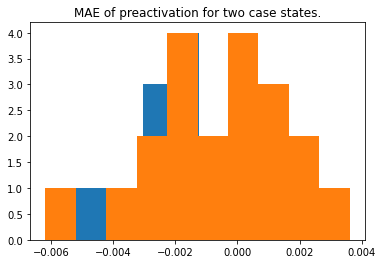

In [26]:
plt.hist(D1)
plt.hist(D2)
plt.title("MAE of preactivation for two case states.")
print("Mean preactivation energy of pred: ", np.mean(D1), " unpred: ", np.mean(D2))
print("Mean difference ratio percent (MDR%) = ", 100*(np.mean(D1) - np.mean(D2)) / np.mean(D2))

[-0.0018898852,
 0.00094540435,
 0.0018315583,
 -0.0058015897,
 5.3499483e-05,
 -0.0012660333,
 -0.002901127,
 -0.0011428918,
 -0.004327598,
 0.00032814668,
 0.001982758,
 -0.001639893,
 0.00088318705,
 0.00026200723,
 0.0013052907,
 -0.0025903978,
 0.00026184059,
 0.003346958,
 -0.0023560063,
 -0.0014358046]